In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from keras import regularizers
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, Input, Lambda, add
from subpixel import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam, RMSprop
from utilities import random_crop, ssim, content_fn, test_edsr, ImageLoader
%matplotlib inline

dtype = 'float32'
K.set_floatx(dtype)

if dtype == 'float16':
    K.set_epsilon(1e-4)

def vgg_preprocess_input(x):
    # BGR Mean values
    vgg_mean = np.array([103.939, 116.779, 123.68], dtype=dtype).reshape((1,1,3))
    return x - vgg_mean


# get output of vgg conv layers function

path = './images/'


bs = 8
scale = 2 # 3 or 4
patch_size = 96
img_size = int(patch_size * scale)

IMAGES = sorted(glob.glob(path + '*'))
sr_trn_gen = ImageLoader(IMAGES, patch_size, scale, batchSize = 16)

Using TensorFlow backend.


Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [3]:
# # Dummy data

# x = np.random.randint(0, 255, size=(1000, 48, 48, 3)).astype(dtype)
# y = np.random.randint(0, 255, size=(1000, 48*scale, 48*scale, 3)).astype(dtype)

In [3]:
def EDSR(scale = 4, input_shape = (48, 48, 3), n_feats = 256, n_resblocks = 32):
    ''' 
        According to the paper scale can be 2,3 or 4. 
        However this code supports scale to be 3 or any of 2^n for n>0
    '''
    def res_block(input_tensor, nf, res_scale = 1.0):
        x = Conv2D(nf, (3, 3), padding='same', activation = 'relu', 
                   activity_regularizer=regularizers.l1(10e-10))(input_tensor)
        x = Conv2D(nf, (3, 3), padding='same', activity_regularizer=regularizers.l1(10e-10))(x)
        x = Lambda(lambda x: x * res_scale)(x)
        x = add([x, input_tensor])
        return x
    inp = Input(shape = input_shape)
    
    x = Conv2D(n_feats, 3, padding='same', activity_regularizer=regularizers.l1(10e-10))(inp)
    conv1 = x
    if n_feats == 256:
        res_scale = 0.1
    else:
        res_scale = 1.0
    for i in range(n_resblocks): x = res_block(x, n_feats, res_scale)
    x = Conv2D(n_feats, 3, padding='same', activity_regularizer=regularizers.l1(10e-10))(x)
    x = add([x, conv1])
    
    if not scale%2:
        for i in range(int(np.log2(scale))):
            x = Subpixel(n_feats, 3, 2, padding='same', activity_regularizer=regularizers.l1(10e-10))(x)
    else: # scale = 3
        x = Subpixel(n_feats, 3, 3, padding='same', activity_regularizer=regularizers.l1(10e-10))(x)
    sr = Conv2D(input_shape[-1], 1, padding='same', 
                activity_regularizer=regularizers.l1(10e-10))(x)
            
    model = Model(inputs=inp, outputs=sr, name = 'SR')
    """ICNR initializer for checkerboard artifact free sub pixel convolution
        Ref:
         [1] Andrew Aitken et al. Checkerboard artifact free sub-pixel convolution
         https://arxiv.org/pdf/1707.02937.pdf)
    """
    for layer in model.layers:
        if type(layer) == Subpixel:
            c, b = layer.get_weights()
            if scale == 3:
                w = icnr_weights(scale=3, shape=c.shape, dtype = dtype)
            else:
                w = icnr_weights(scale=2, shape=c.shape, dtype = dtype)
            layer.set_weights([w, b])
    return model

In [4]:
edsr_model = EDSR(scale = scale, input_shape = (patch_size, patch_size, 3), 
                  n_feats = 256, n_resblocks = 32)

### EDSR paper's implementation

In [6]:
edsr_model.load_weights('sr_x{}.h5'.format(scale))
edsr_model.compile(Adam(lr=1e-4, decay=0.9), loss='mae', metrics=[ssim])

checkpointer = ModelCheckpoint(filepath = 'sr_x{}.h5'.format(scale), verbose=1, 
                               save_best_only=True, save_weights_only=True,
                               monitor = 'loss')

callbacks = [TQDMNotebookCallback(), checkpointer, 
             TensorBoard()]

edsr_model.fit_generator(sr_trn_gen, len(sr_trn_gen), epochs=3, verbose=0, 
                         callbacks=callbacks, workers=8, use_multiprocessing=True)


Epoch 00001: loss improved from inf to 77.75383, saving model to sr_x2.h5



Epoch 00002: loss improved from 77.75383 to 44.29911, saving model to sr_x2.h5



Epoch 00003: loss improved from 44.29911 to 34.35395, saving model to sr_x2.h5



Epoch 00004: loss improved from 34.35395 to 27.60140, saving model to sr_x2.h5



Epoch 00005: loss improved from 27.60140 to 24.19707, saving model to sr_x2.h5



Epoch 00006: loss improved from 24.19707 to 22.08004, saving model to sr_x2.h5



Epoch 00007: loss improved from 22.08004 to 20.35746, saving model to sr_x2.h5



Epoch 00008: loss improved from 20.35746 to 18.86288, saving model to sr_x2.h5



Epoch 00009: loss improved from 18.86288 to 17.86511, saving model to sr_x2.h5



Epoch 00010: loss improved from 17.86511 to 17.28348, saving model to sr_x2.h5



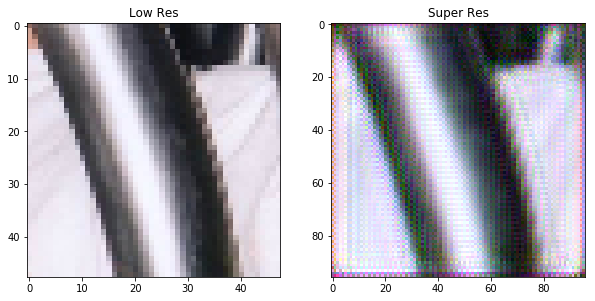

In [8]:
test_edsr(edsr_model, x[8][:,:,::-1])

### EDSR With MAE and Perceptual Loss (VGG16)

In [24]:
edsr_model = EDSR(scale = scale, input_shape = (patch_size, patch_size, 3), 
                  n_feats = 256, n_resblocks = 32)

HR = Input((img_size, img_size, 3), name = 'HR')
LR = Input((patch_size, patch_size, 3), name = 'LR')
SR = edsr_model(LR)

vgg = VGG16(include_top=False, weights='imagenet', 
            input_tensor=Lambda(vgg_preprocess_input)(HR))
for l in vgg.layers: l.trainable = False


# get perceptual\content outputs

def get_output(m, ln): return m.get_layer('block{}_conv2'.format(ln)).output

vgg_content = Model(HR, [get_output(vgg, o) for o in [1,2,3]], name = 'Partial-VGG16')
vgg1 = vgg_content(HR) # content of HR
vgg2 = vgg_content(SR) # content of SR


# Create Perceptual Loss
loss_con = Lambda(content_fn, name = 'Content')(vgg1+vgg2)


model = Model([LR, HR], [SR, loss_con])
losses = ['SR', 'Content']
weights = [1., 1.]

checkpointer = ModelCheckpoint(filepath = 'sr_multi_loss_x{}.h5'.format(scale), verbose=1, 
                               save_best_only=True, save_weights_only=True,
                               monitor = 'loss')

callbacks = [TQDMNotebookCallback(), checkpointer, TensorBoard()]

model.compile(Adam(lr=1e-4, decay=0.9), loss = {loss : 'mae' for loss in losses}, 
              loss_weights = weights, metrics={'SR' : ssim})


sr_trn_gen = ImageLoader(IMAGES, patch_size, scale, batchSize = 16, multi_loss=True)
model.fit_generator(sr_trn_gen, len(sr_trn_gen), epochs=30, verbose=0, 
                    callbacks=callbacks, workers=8, use_multiprocessing=True)



Epoch 00001: loss improved from inf to 34.24871, saving model to sr_multi_loss_x2.h5



Epoch 00002: loss improved from 34.24871 to 27.99718, saving model to sr_multi_loss_x2.h5



Epoch 00003: loss improved from 27.99718 to 26.93084, saving model to sr_multi_loss_x2.h5



Epoch 00004: loss improved from 26.93084 to 25.30946, saving model to sr_multi_loss_x2.h5



Epoch 00005: loss improved from 25.30946 to 24.81123, saving model to sr_multi_loss_x2.h5



Epoch 00006: loss improved from 24.81123 to 24.43220, saving model to sr_multi_loss_x2.h5



Epoch 00007: loss improved from 24.43220 to 23.98002, saving model to sr_multi_loss_x2.h5



Epoch 00008: loss did not improve from 23.98002



Epoch 00009: loss improved from 23.98002 to 23.76163, saving model to sr_multi_loss_x2.h5



Epoch 00010: loss improved from 23.76163 to 23.53646, saving model to sr_multi_loss_x2.h5



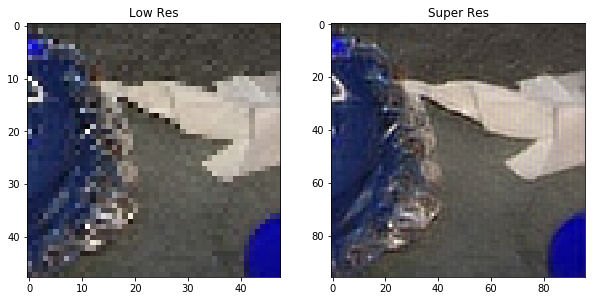

In [25]:
test_edsr(edsr_model, x[25])